# Use Case

**Objective**: 2)[selected problem] Build a 6-month forecast of the monthly sum of the variable VALUE_EUR for all HKONT values


In [2]:
import pandas as pd
import mlflow
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

import mlflavors
import requests
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA,
    SeasonalExponentialSmoothing,
    AutoETS
    )

/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Data Pipeline - Custom Functions

In [5]:
#1
def load_csv_data(path:str) -> pd.DataFrame:
    """
    loading csv file data
    """
    df = pd.read_csv(path)
    return df

#2
def date_col_transform(df:pd.DataFrame, col:str='DATUM') -> pd.DataFrame:
    """
    to convert DATUM to timestamp format
    """
    df[col] = pd.to_datetime(df[col])
    return df

#3
def date_col_extract(df:pd.DataFrame, col:str='DATUM') -> pd.DataFrame:
    """
    extracting month and year value from DATUM columns and saving as new columns.
    """
    df['DATUM_MONTH'] = df[col].dt.month
    df['DATUM_YEAR'] = df[col].dt.year 
    return df

#4
def agg_month_data(df:pd.DataFrame) -> pd.DataFrame:
    """
    aggregating data on monthly level for each HKONT.
    """
    df_agg = df.groupby([df['HKONT'], df['DATUM_YEAR'], df['DATUM_MONTH']])['VALUE_EUR'].sum().reset_index()
    return df_agg

#5
def date_add_agg_level(df:pd.DataFrame) -> pd.DataFrame:
    """
    adding a column for date after aggregating at month level
    setting date as index
    """
    df['DATUM_AGG'] = pd.to_datetime(df['DATUM_YEAR'].astype(str) + '-' + 
                                     df['DATUM_MONTH'].astype(str) + '-1')
    # df.set_index('DATUM_AGG', inplace=True)
    return df

#6
def data_selection(df:pd.DataFrame) -> pd.DataFrame:
    """
    formatting columns as per statsforecast module
    """
    col = ['DATUM_AGG', 'HKONT', 'VALUE_EUR']
    col_sf = ['ds', 'unique_id', 'y']
    data_ = df[col]
    data_.columns = col_sf
    return data_

#7
def time_series_selection(df:pd.DataFrame) -> pd.DataFrame:
    """
    for selecting time-series with appropriate data points (hkont: timestamps)
    """
    ts_dict = (df.HKONT.value_counts(ascending=False)).to_dict()
    ts_dict = {key: value for key, value in ts_dict.items() if value < 12}
    for i in ts_dict.keys():
        data_idx = df[df['HKONT'] == i].index
        df = df.drop(data_idx)
    return df

# data processing pipeline
def data_pipeline():
    df = load_csv_data(path='training_data.csv')
    df = date_col_transform(df)
    df = date_col_extract(df)
    df_agg = agg_month_data(df)
    df_agg = date_add_agg_level(df_agg)
    df_agg = time_series_selection(df_agg)
    df_out = data_selection(df_agg)
    return df_out
    

## ML Training and Experiments

In [6]:
from mlflow import MlflowClient
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

experiment_name = 'Siemens use case'
mlflow.set_experiment(experiment_name)

2024/05/11 19:25:01 INFO mlflow.tracking.fluent: Experiment with name 'Siemens use case' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/nirmal/Documents/np_dsci_codes/Forecasting_Use_Case/mlruns/895298913717038909', creation_time=1715448301205, experiment_id='895298913717038909', last_update_time=1715448301205, lifecycle_stage='active', name='Siemens use case', tags={}>

In [10]:
ARTIFACT_PATH = "model"
DATA_PATH = "./data"
HORIZON = 12
LEVEL = [90]
def ml_training_with_cv(model, model_name:str, plot:bool=True):

    # Check if there is an active run and end it
    if mlflow.active_run() is not None:
        mlflow.end_run()

    # mlflow run
    mlflow.autolog()    
    with mlflow.start_run() as run:
        mlflow.autolog()
        # data
        data = data_pipeline()
        
        #model
        models = model

        #solver
        sf = StatsForecast(df=data, 
                        models=models, 
                        freq="M", 
                        n_jobs=-1)
        
        #cv
        crossvalidation_df = sf.cross_validation(df = data,
                                                h = 6,
                                                step_size = 1,
                                                n_windows = 3)
        crossvalidation_df.fillna(0, inplace=True)
        
        #model fit
        sf.fit()

        # forecast
        forecast_df = sf.forecast(df=data, h=6, level=[90])
        forecast_df.fillna(0, inplace=True)

        # Evaluate model
        mae = mean_absolute_error(crossvalidation_df['y'], crossvalidation_df[model_name])
        mape = mean_absolute_percentage_error(crossvalidation_df['y'], crossvalidation_df[model_name])
        # y_pred = sf.predict(h=HORIZON,  level=LEVEL)["AutoARIMA"]

        metrics = {
            "mae": mae,
            "mape": mape,
        }

        print(f"Metrics: \n{metrics}")

        # Log metrics
        mlflow.log_metrics(metrics)

        # Log model using pickle serialization (default).
        mlflavors.statsforecast.log_model(
            statsforecast_model=sf,
            artifact_path=ARTIFACT_PATH,
            serialization_format="pickle",
        )
        model_uri = mlflow.get_artifact_uri(ARTIFACT_PATH)
    if plot:
        plt = StatsForecast.plot(df=data, forecasts_df=forecast_df, level=[90])
    print(f"\nMLflow run id:\n{run.info.run_id}")
    return data, forecast_df, mae, mape, plt

## AutoARIMA

2024/05/12 00:00:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/05/12 00:00:45 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2024/05/12 00:00:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/05/12 00:00:45 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/05/12 00:00:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2024/05/12 00:00:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/05/12 00:00:46 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a su

Metrics: 
{'mae': 151562.77, 'mape': 22.624817}


2024/05/12 00:01:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/tmpwtggm1ho/model/model.pkl, flavor: statsforecast). Fall back to return ['statsforecast==1.7.4']. Set logging level to DEBUG to see the full traceback. 
/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/statsforecast/core.py:1329: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(



MLflow run id:
f58d1b0e29904db5ac5596d654972c7d


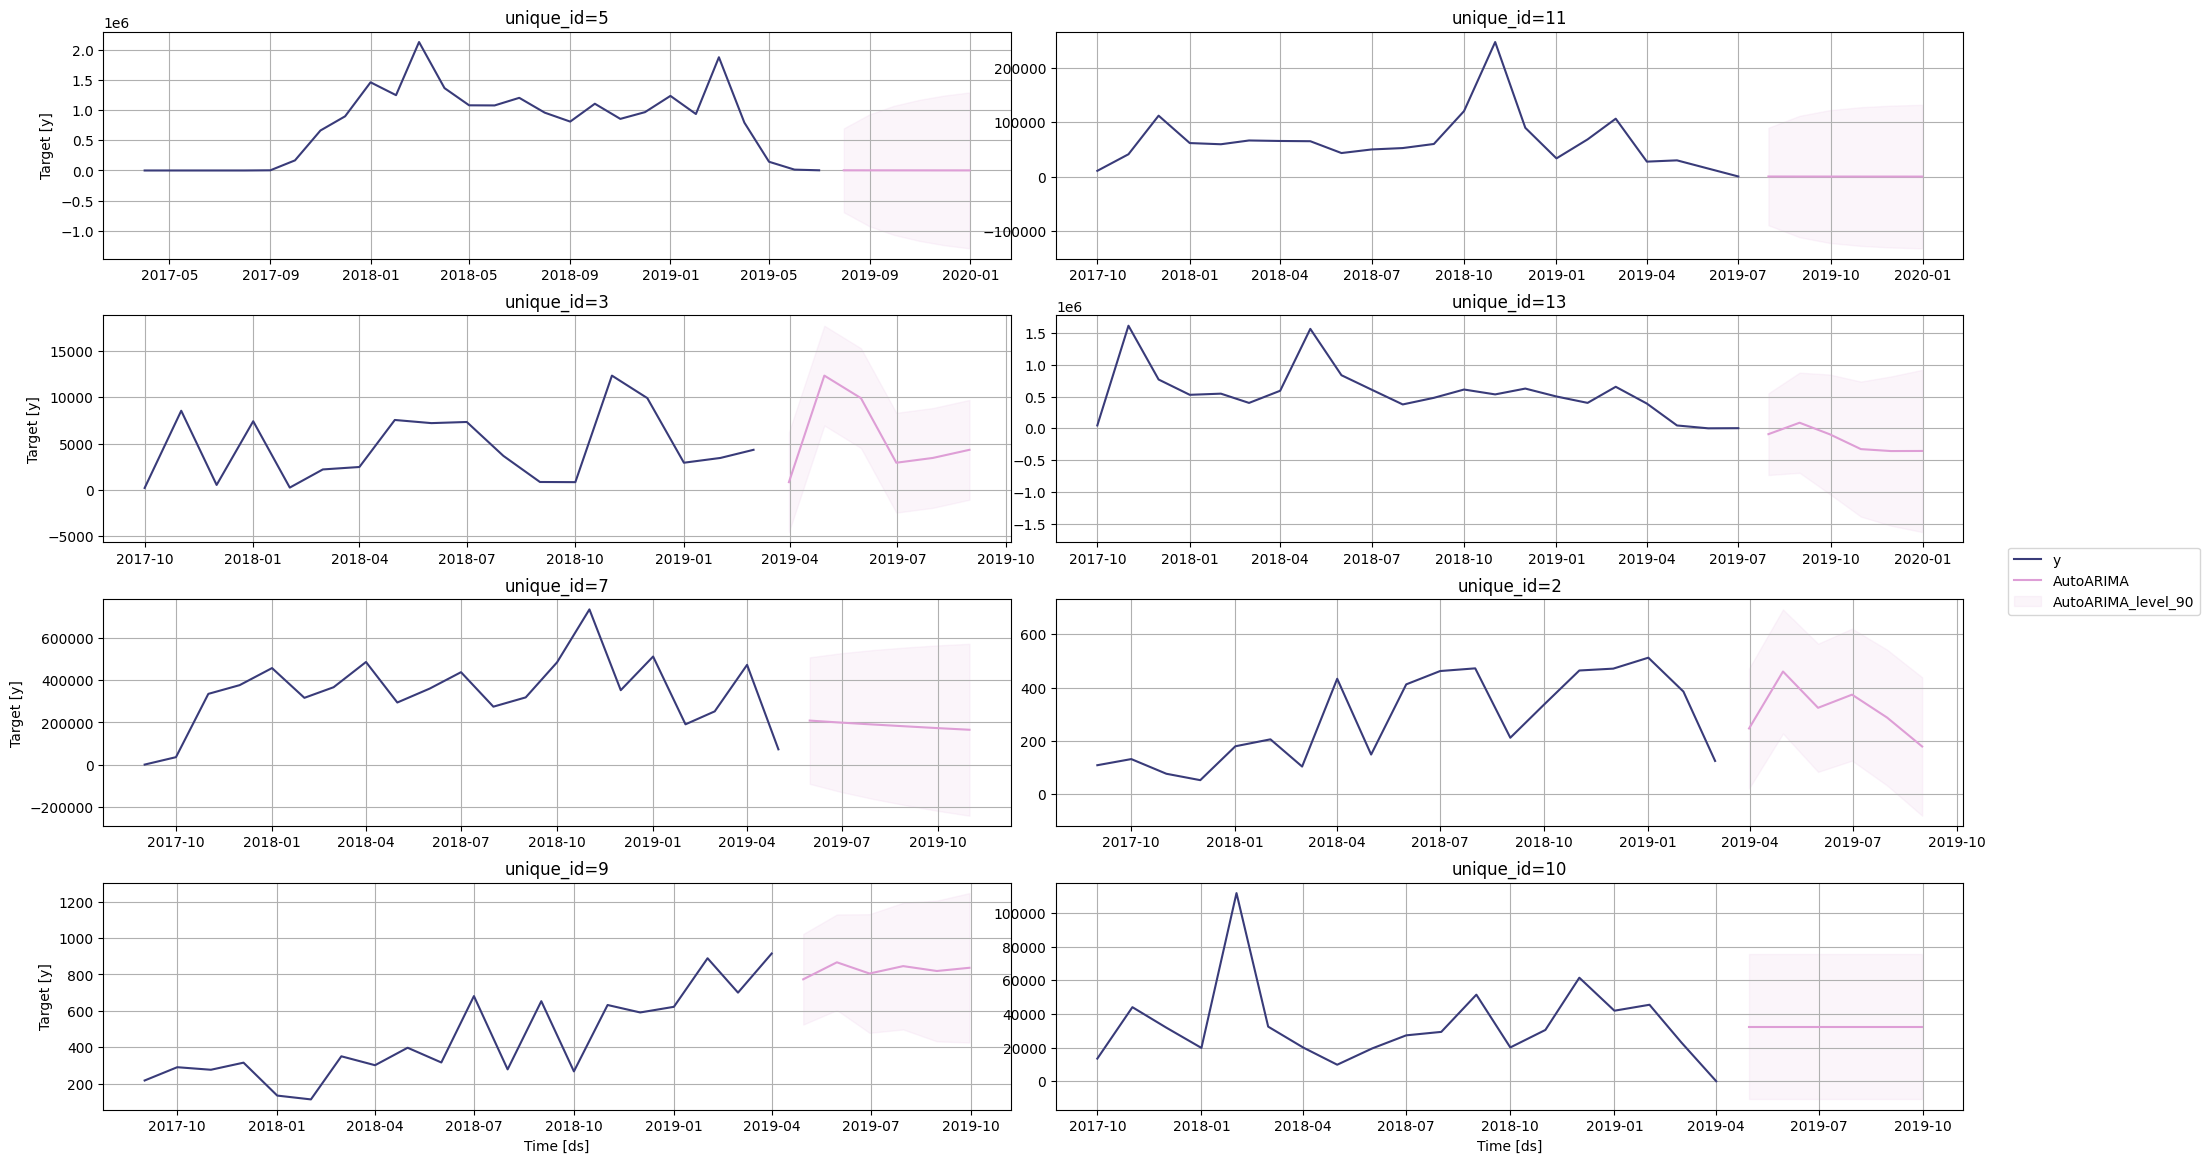

In [11]:
# AutoARIMA
data, forecast_df, mae, mape, plt = ml_training_with_cv(model=[AutoARIMA(season_length=6, seasonal=True)], model_name='AutoARIMA')
display(plt)

## Seasonal Naive

2024/05/12 00:02:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/05/12 00:02:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2024/05/12 00:02:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/05/12 00:02:16 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/05/12 00:02:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2024/05/12 00:02:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/05/12 00:02:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a su

Metrics: 
{'mae': 141135.33, 'mape': 20.999916}


2024/05/12 00:02:25 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/tmpt6cq5b_m/model/model.pkl, flavor: statsforecast). Fall back to return ['statsforecast==1.7.4']. Set logging level to DEBUG to see the full traceback. 
/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/statsforecast/core.py:1329: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(



MLflow run id:
98bc1c359d7d4ad6ad2a2e0830fc1a2a


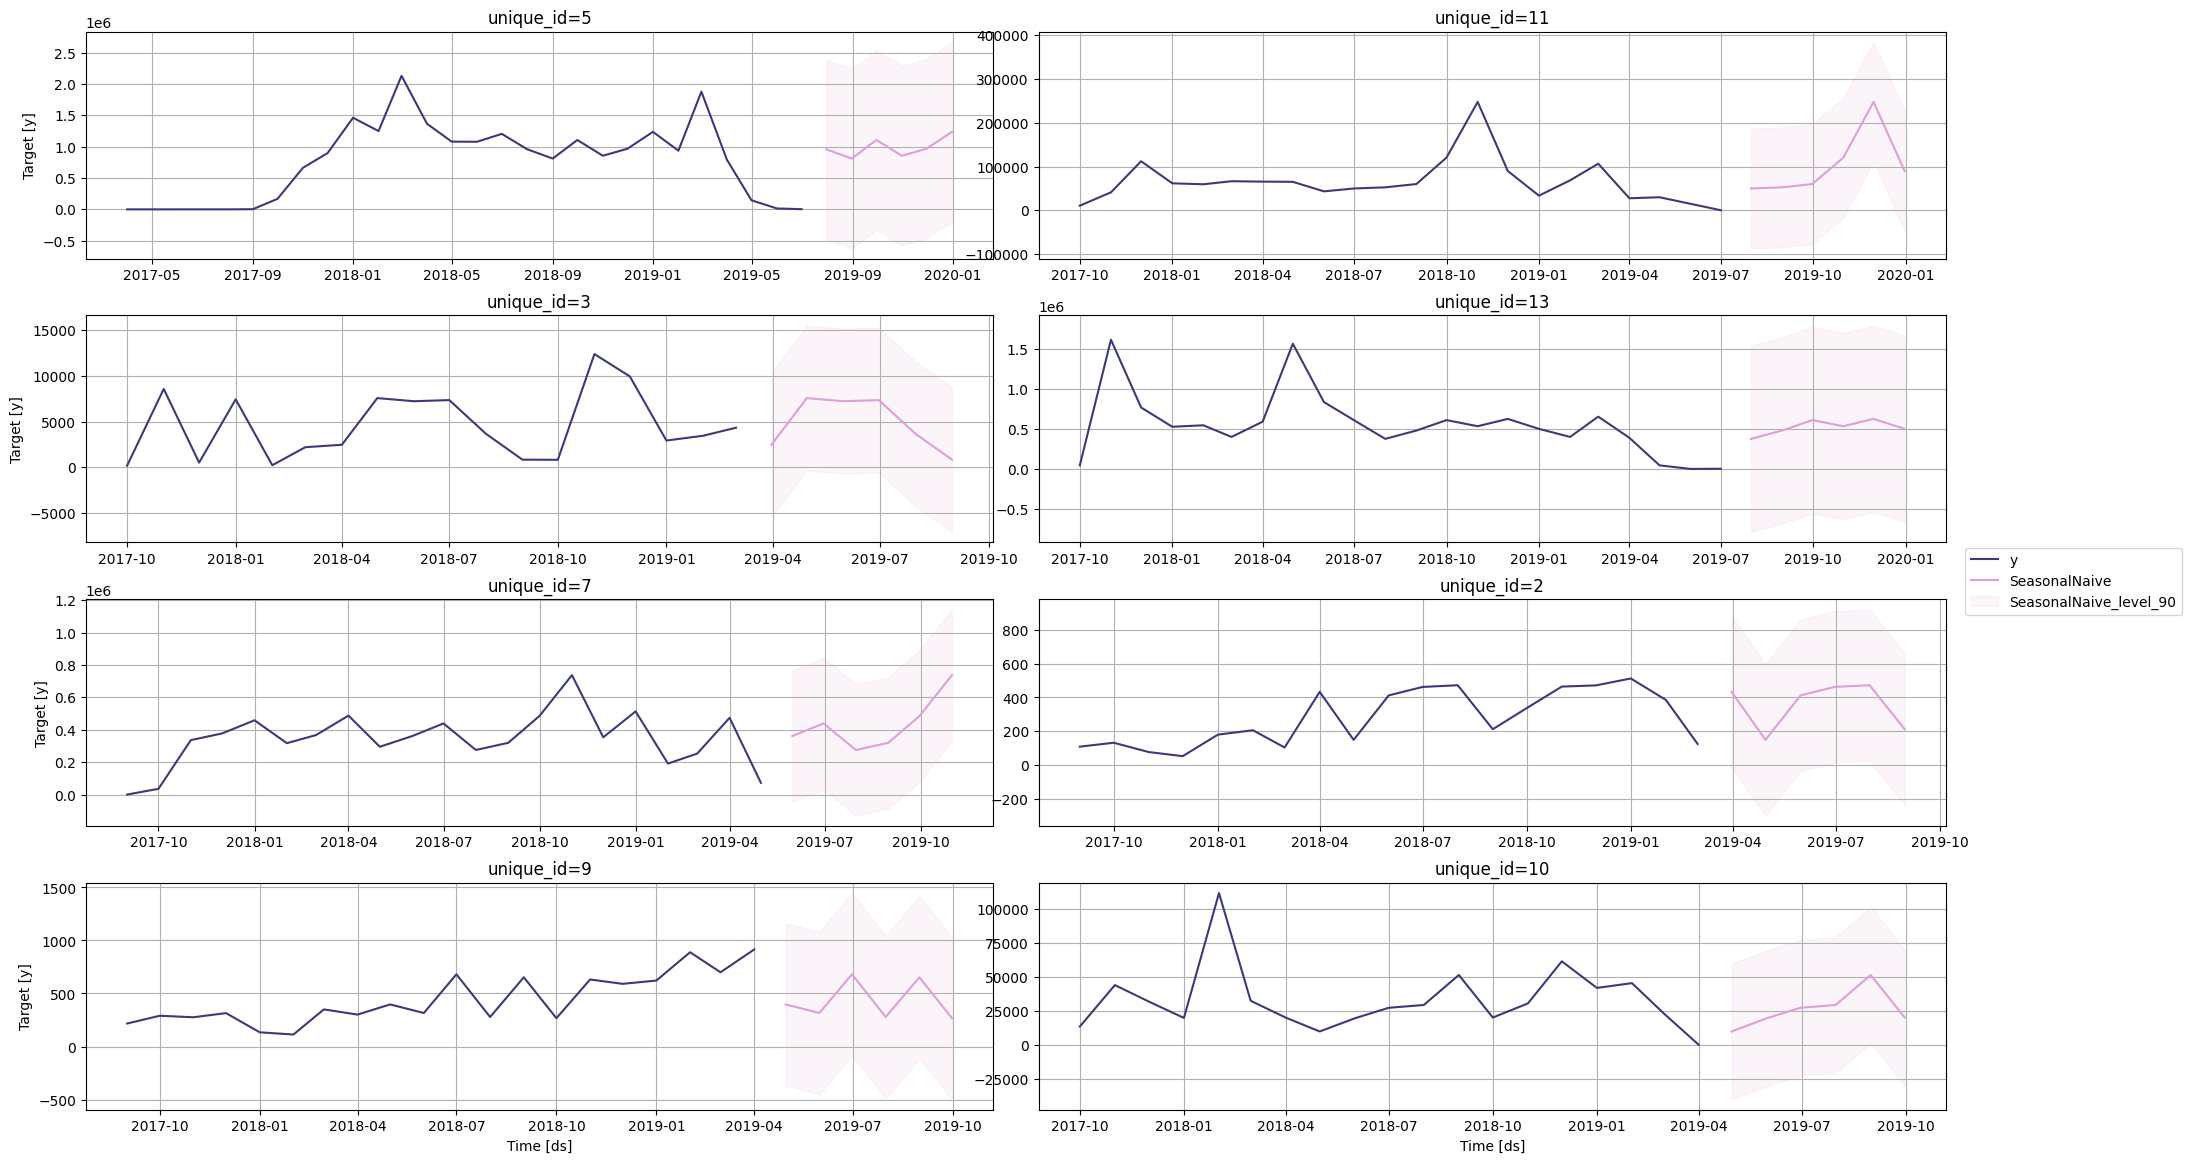

In [12]:
# SeasonalNaive Method
data, forecast_df, mae, mape, plt = ml_training_with_cv(model=[SeasonalNaive(season_length=12)], model_name='SeasonalNaive')
display(plt)

## Combine Training and Comparison

In [6]:
def combined_forecast(data:pd.DataFrame):
    """
    comparing 12 months forecast to choose better model for production
    """
    from statsforecast.models import (
        HoltWinters,
        CrostonClassic as Croston, 
        HistoricAverage,
        DynamicOptimizedTheta as DOT,
        SeasonalNaive,
        AutoARIMA,
        SeasonalExponentialSmoothing,
        AutoETS
        )
    models = [
        HoltWinters(),
        Croston(),
        SeasonalNaive(season_length=12),
        HistoricAverage(),
        DOT(season_length=3),
        AutoARIMA(season_length=1, seasonal=True),
        SeasonalExponentialSmoothing(season_length=12, alpha=0.9),
        AutoETS(season_length=12)
    ]
    # Instantiate StatsForecast class as sf
    mlflow.autolog()
    sf = StatsForecast( 
        models=models,
        freq='M', 
        fallback_model = SeasonalNaive(season_length=7),
        n_jobs=-1,
    )
    forecasts_df = sf.forecast(df=data, h=6, level=[90])
    plt = sf.plot(df=data, forecasts_df=forecasts_df)
    return plt

2024/05/11 21:35:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/05/11 21:35:07 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2024/05/11 21:35:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/05/11 21:35:07 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/05/11 21:35:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/statsforecast/ets.py:1038: RuntimeWarning: divide by zero encountered in divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/statsforecast/ets.py:1038: Runti

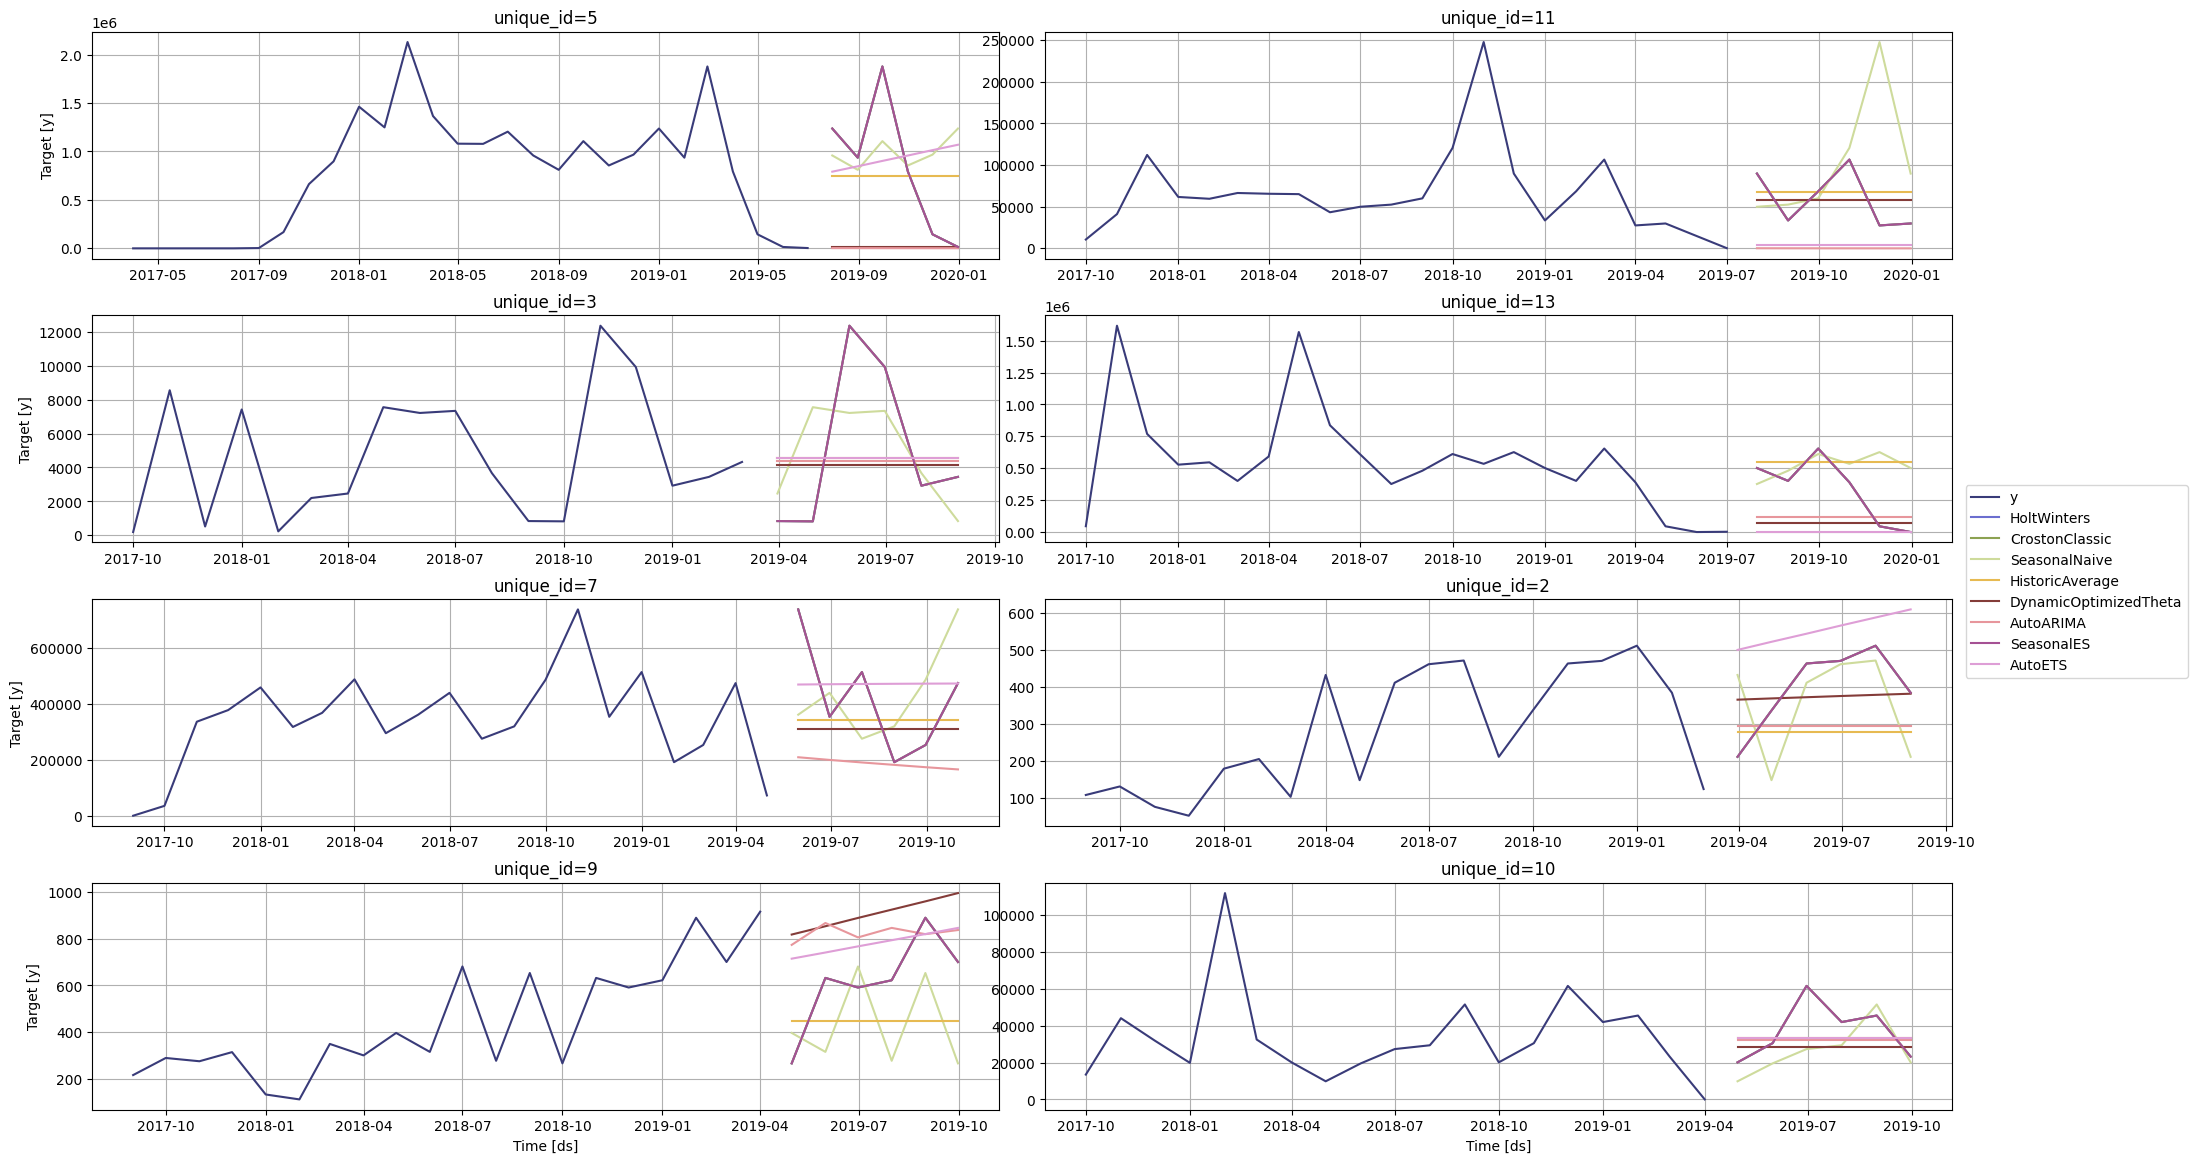

In [9]:
data = data_pipeline()
plt = combined_forecast(data=data)
display(plt)

## Thoughts on another case study

**Idea**: 1) Build a predictor to inform whether a payment occurs ahead of time, on time or if it's delayed.
       You consider that a payment is on time if it occurs during the same month of the due date.

- data EDA (not sure which column can be used to decide problem granularity)
- feature engineering - create one column with ordinal encoding that shows payment status (0=ontime, 1=before time, 2=late payment)
- feature selection - a little do with domain & data knowledge along with DS tools
- need to perform encoding (ordinal, categorical, or one-hot)
- Model selection - multi classification model such xgboost, random forest classifier, etc
- Model training with various selected model & model evaluation
- Champion model selection